In [1]:
from orqviz.utils import load_viz_object
from orqviz.scans import plot_2D_scan_result, plot_1D_interpolation_result
from orqviz.pca import (get_pca,
                        plot_pca_landscape,
                        plot_optimization_trajectory_on_pca)
from divisiveclustering.datautils import DataUtils
import numpy as np
import matplotlib.pyplot as plt
from divisiveclustering.plotsutils import get_trajectories_collection, plot_optimization_trajectory
import pickle
import pennylane as qml

In [2]:
from divisiveclustering.quantumutils._quantumutils import vqe_ansatz, create_Hamiltonian_for_K2

In [9]:
# parameters
centers = 4
dimensions = 2
number_of_rows = 1000
random_state = 10
save_file = False

number_of_runs = 10
coreset_numbers = 5
vector_list_size = 10

shots = 100
depth = 1

In [4]:
# create a random data
from divisiveclustering.datautils import DataUtils
data_creation = DataUtils()
raw_data = data_creation.create_new_data_set(number_of_rows, centers, dimensions, random_state, save_file=save_file)

In [5]:
raw_data

array([[ 4.4016599 , -9.42456185],
       [-6.12795872,  5.01025395],
       [-6.25332117,  5.01582549],
       ...,
       [-5.29208972,  4.54111279],
       [ 5.77276444, -8.64259652],
       [ 1.54076696,  4.06513159]])

In [6]:
# create coreset
from divisiveclustering.coresetsUtils import Coreset
from divisiveclustering.coresetsUtils import coreset_to_graph

coresetutil = Coreset()

coreset_vector, coreset_weights = coresetutil.get_coresets(
    data_vectors=raw_data, number_of_runs=number_of_runs, coreset_numbers=coreset_numbers, size_vec_list=vector_list_size
)

best_coreset_vectors, best_coreset_weights = coresetutil.get_best_coresets(raw_data, coreset_vector, coreset_weights)



coreset_points, G, H, weight_matrix, weights = coreset_to_graph(
    best_coreset_vectors, best_coreset_weights, metric="dot"
)
qubits = len(G.nodes)

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: F

In [10]:
# quantum variables
dev = qml.device("qulacs.simulator", wires=qubits, shots=shots)
cost_H = create_Hamiltonian_for_K2(G, weights, nodes=qubits, add_identity=False)
params = np.random.random(qubits * 4 * depth)

In [11]:
params

array([0.63074619, 0.18619837, 0.95120866, 0.89232863, 0.5454123 ,
       0.7421312 , 0.07091227, 0.69868461, 0.3640498 , 0.01647817,
       0.75150401, 0.26346899, 0.06646533, 0.72757068, 0.88520406,
       0.44593946, 0.00195265, 0.09695532, 0.06582929, 0.10218086])

In [14]:
# VQE ansatz
from divisiveclustering.quantumutils import (
    vqe_ansatz,
)


vqe_ansatz(params, qubits, depth, G, dev)

In [16]:
fig, ax = qml.draw_mpl(vqe_ansatz)(params)

AttributeError: 'function' object has no attribute 'construct'

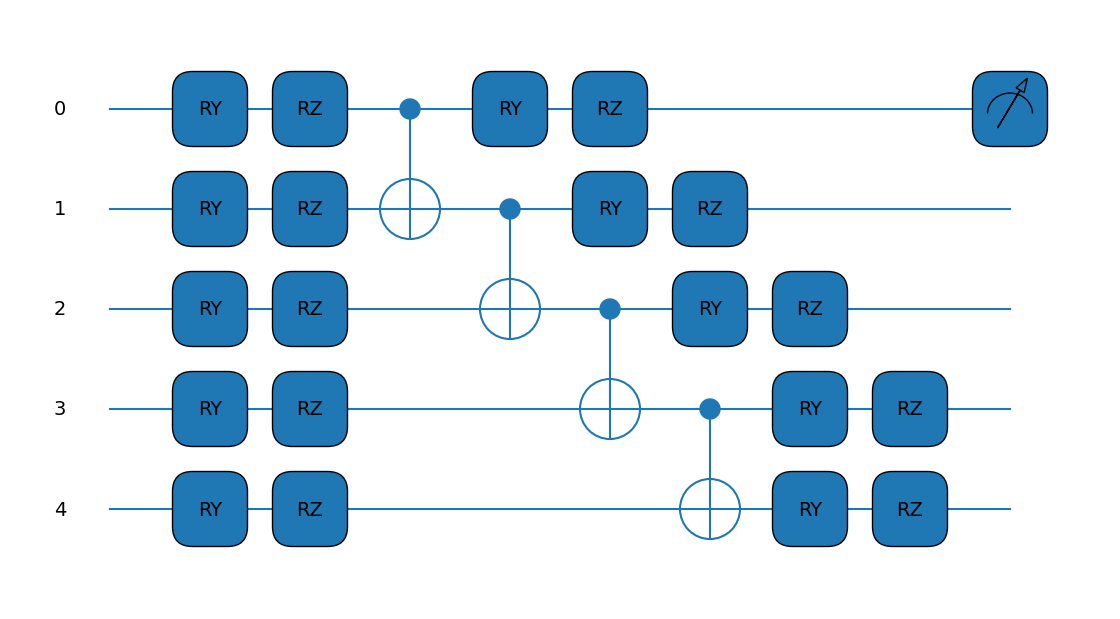

In [27]:
@qml.qnode(dev)
def circuit(params: np.ndarray, wires, depth: int, G, dev):
    """
    Create VQE ansatz for the problem

    Args:
        params: circuit parameters
        wires: wires of the circuit
        depth: circuit depth
        G: Problem as a graph
        dev: device information from pennylane
    """

    wires = len(dev.wires)

    params_p = params.reshape(depth, 4, -1)

    for p in range(depth):
        theta_vals = params_p[p]

        for wire in range(wires):

            qml.RY(theta_vals[0][wire], wires=wire)
            qml.RZ(theta_vals[1][wire], wires=wire)

            if wire > 0:
                qml.CNOT(wires=[wire - 1, wire])

        for wire in range(wires):
            qml.RY(theta_vals[2][wire], wires=wire)
            qml.RZ(theta_vals[3][wire], wires=wire)
            
    return qml.expval(qml.PauliZ(0))

qml.drawer.use_style('default')
fig, ax = qml.draw_mpl(circuit)(params = params, wires = qubits, depth = 1, G = G, dev = dev)

In [28]:
def vqe_circuit(G, params, entanglement='linear'):
    '''
    Builds the vqe circuit from the problem graph.
    Inputs:
    G: type networkx graph object - the problem graph
    params: type array - 2 * number of qubit parameters
            for the RY and RX gate (RY params followed by
            RX params.)
    entanglement: linear - one CNOT applied between adjacent
                           qubits (default).
                  full - CNOT applied between all qubits.
    '''
    #Number of qubits is 2x number of data points/vertices
    num_qubits = 2 * len(list(G.nodes))
    #Initialise circuit with equal number of qubits and classical bits
    circuit = QuantumCircuit(num_qubits, num_qubits)
    Rx_index = 0
    Ry_index = int(len(params) / 2)
    while Rx_index <= int((len(params) / 2) - 1):
        #Add RY followed by RX gates on each qubit
        for i in range(num_qubits):
            circuit.ry(params[Rx_index], i)
            circuit.rx(params[Ry_index], i)
            Rx_index +=1
            Ry_index +=1

        circuit.barrier()
        if Rx_index <= int((len(params) / 2) - 2):
            #Add CNOT's to entangle qubits - either linear or full entanglement
            if entanglement == 'linear':
                #Total number of CNOTs in linear entanglement case
                no_cnots = num_qubits - 1
                for i in range(no_cnots):
                    circuit.cnot(i, i + 1)
            if entanglement == 'full':
                #Number of CNOTs with 0 as control in full entanglement case
                no_cnots = num_qubits - 1
                for i in range(no_cnots):
                    for j in range(i + 1, num_qubits):
                        circuit.cnot(i, j)

            circuit.barrier()
        else:
            pass
    #Measure all qubits and write out to classical bits
    circuit.measure(range(num_qubits), range(num_qubits))
    return circuit

def draw_circuit(circuit):
    circuit.draw('mpl', style='iqx', fold=50)
    plt.show()